In [1]:
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
import pickle

In [4]:
import numpy as np
from scipy.stats import poisson, norm

In [5]:
def compute_scaling_ratio(mu_drain,mu_demand,drift_sd,init_state):
    drain_time = init_state/(mu_drain-mu_demand)
    accum_std = drift_sd*np.sqrt(drain_time)
    ratio = accum_std/init_state
    
    return ratio

In [6]:
c1 = 1
c2 = 2
c3 = 3

In [7]:
def simulate_reflected_random_walk_repeat(arrival_sequence,
                                          transfer_sequence,
                                          fast_sequence,
                                          drain_sequence,
                                          h_thres,ss_thres,
                                          init_state,flow):
    arrival_buffer = np.zeros(len(arrival_sequence)+1)
    intermediate_buffer = np.zeros(len(arrival_sequence)+1)
    drain_buffer = np.zeros(len(arrival_sequence)+1)
    arrival_buffer[0] = init_state
    intermediate_buffer[0] = max(0,h_thres-ss_thres)
    drain_buffer[0] = min(ss_thres,h_thres)
    n_idles = 0
    idling_benefit = 0
    idling_benefit_2 = 0
    completed = False
    for i,(a,t,f,d) in enumerate(zip(arrival_sequence,transfer_sequence,fast_sequence,drain_sequence)):
        if flow:
            t = min(t,arrival_buffer[i]+a)
            f = min(f,intermediate_buffer[i]+t)
            d = min(d,drain_buffer[i]+f)
        else:
            t = min(t,arrival_buffer[i])
            f = min(f,intermediate_buffer[i])
            d = min(d,drain_buffer[i])
            
        if intermediate_buffer[i]+drain_buffer[i] > h_thres:
            t = 0
            n_idles += 1
            idling_benefit += a-d
            idling_benefit_2 += a-min(d,drain_buffer[i])
            
        if drain_buffer[i] > min(ss_thres,h_thres):
            f = 0

        
        arrival_buffer[i+1] = max(0,arrival_buffer[i]+a-t)
        intermediate_buffer[i+1] = max(0,intermediate_buffer[i]+t-f)
        drain_buffer[i+1] = max(0,drain_buffer[i]+f-d)
        
    #print(n_idles,idling_benefit,idling_benefit_2)
    return arrival_buffer,intermediate_buffer,drain_buffer,(len(arrival_sequence)-n_idles)/len(arrival_sequence)

# drain resource is the main bottleneck

In [8]:
c1 = 1
c2 = 2
c3 = 3

In [9]:
n = int(1e6)

scale = 3

mu_demand = 30*scale
mu_drain = mu_demand*1.02
mu_transfer = mu_drain + (mu_drain-mu_demand)*1
#mu_fast = 

np.random.seed(5)

demand_seq = np.random.poisson(mu_demand,n)
transfer_seq = np.random.poisson(mu_transfer,n)
drain_seq = np.random.poisson(mu_drain,n)

#demand_seq = norm.rvs(mu_demand,np.sqrt(mu_demand),n)
#supply_seq = norm.rvs(mu_supply,np.sqrt(mu_supply),n)

In [77]:
costs = {}
betas = {}
sc_ratios = {}
eff_rates = {}

In [78]:
percentile = 4

In [79]:
hedging = np.concatenate((np.arange(0,20,2),np.arange(20,150,10)))

In [82]:
#scale_list = [0.1,0.3,1,3]
#scale_list = [0.2,0.4,0.5,0.6,0.7]
scale_list = [0.33]

hedging = np.concatenate((np.arange(0,20,2),np.arange(20,150,10)))
#hedging = np.arange(0,150,10)
hedging = np.arange(50,600,50)
#hedging = np.arange(0,20,2)
#hedging = np.arange(7,8,1)
hedging = [beta_h]

# settings for scale = 3
dur_star = 10000
omega_star = 7.5645
#init_state_star = 210000

#dur_star = int(4500000*1)
duration = dur_star

for scale in reversed(scale_list):
    #print(scale)
    scale_costs = []
    scale_rates = []
    
    #init_state = 7e4*scale
    
    mu_demand = scale
    mu_drain = mu_demand*1.02
    mu_transfer = mu_drain + (mu_drain-mu_demand)*1
    #mu_fast = mu_drain + (mu_drain-mu_demand)*30
    mu_fast = 2*mu_demand
    
    slack_capacity_h = mu_transfer-mu_drain
    std_h = np.sqrt(mu_drain*(1-mu_drain)+mu_transfer*(1-mu_transfer))
    
    omega_h = std_h/slack_capacity_h
    
    
    slack_capacity_ss = mu_fast-mu_drain
    std_ss = np.sqrt(mu_fast*(1-mu_fast)+mu_drain*(1-mu_drain))
    
    omega_ss = std_ss/slack_capacity_ss
    
    
    duration = int(4.5*omega_h**2*(c2/c1)/0.03)
    print(scale,duration)
    #print(scale,omega)
    #continue
    
    #print(omega/omega_star)
    
    #duration = int((omega/omega_star)**2*dur_star)
    init_state = slack_capacity_h*duration*0.5
    
    beta_h = (1/4)*(percentile**2)*omega_h# + slack_capacity/std
    beta_ss = (1/4)*(percentile**2)*omega_ss
    scaling_ratio = compute_scaling_ratio(mu_drain,mu_demand,std_h,init_state)
    print(scaling_ratio)

    np.random.seed(5)

    demand_seq = np.random.binomial(1,mu_demand,duration)
    transfer_seq = np.random.binomial(1,mu_transfer,duration)
    fast_seq = np.random.binomial(1,mu_fast,duration)
    drain_seq = np.random.binomial(1,mu_drain,duration)
    
    hedge = True
    
    for h in reversed(hedging):
        print(h)
        if hedge:
            h_thres = 2*mu_drain+h*std_h
            ss_thres = 2*mu_drain+beta_ss*std_ss
        else:
            h_thres = 2*mu_drain+beta_h*std_ss
            ss_thres = 2*mu_drain+h*std_ss
        #thres = 2*mu_drain+h*np.sqrt(mu_drain+mu_fast)
        #thres = h*10
        arrival_buffer,inter_buffer,drain_buffer,zeta = simulate_reflected_random_walk_repeat(
            demand_seq[:duration],
            transfer_seq[:duration],
            fast_seq[:duration],
            drain_seq[:duration],
            h_thres=h_thres,
            ss_thres=ss_thres,
            init_state=init_state,
            flow=False)
        scale_costs.append((sum(arrival_buffer*c1),sum(inter_buffer*c2),sum(drain_buffer*c3)-2*mu_drain*len(drain_buffer)*c3))
        scale_rates.append(zeta*mu_transfer)
        #scale_costs.append(sum(arrival_buffer*c1))
        
    costs[scale] = np.array(scale_costs[::-1])
    betas[scale] = beta_h
    sc_ratios[scale] = scaling_ratio
    eff_rates[scale] = np.array(scale_rates[::-1])

0.33 3090318
0.08164966049469251
405.9765629897494


In [54]:
beta_ss = (1/4)*(percentile**2)*omega_ss

In [55]:
beta_ss

8.275871454925145

In [56]:
mu_demand,mu_transfer,mu_fast,mu_drain

(0.33, 0.3432, 0.66, 0.3366)

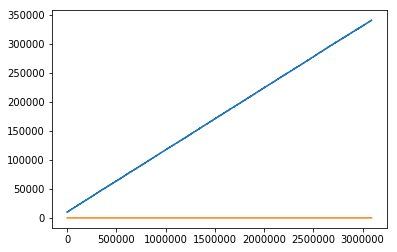

In [57]:
plt.plot(arrival_buffer[:10000000])
plt.plot(inter_buffer[:10000000])

In [76]:
beta_h*std_h/(beta_ss*std_ss)

49.11095419070846

In [66]:
beta_h

405.9765629897494

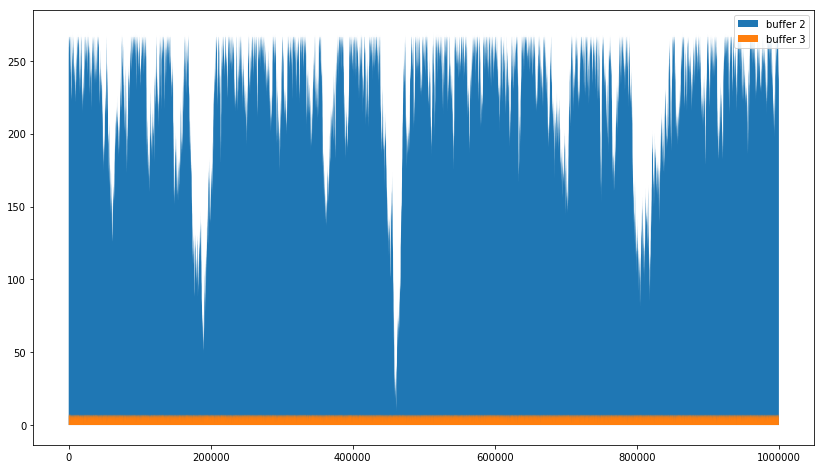

In [84]:
plt.figure(figsize=(14,8))
run = np.arange(1000000)
plt.fill_between(run,inter_buffer[run],label="buffer 2")
plt.fill_between(run,drain_buffer[run],label="buffer 3")
plt.legend()

In [74]:
omega_h

101.49414074743736

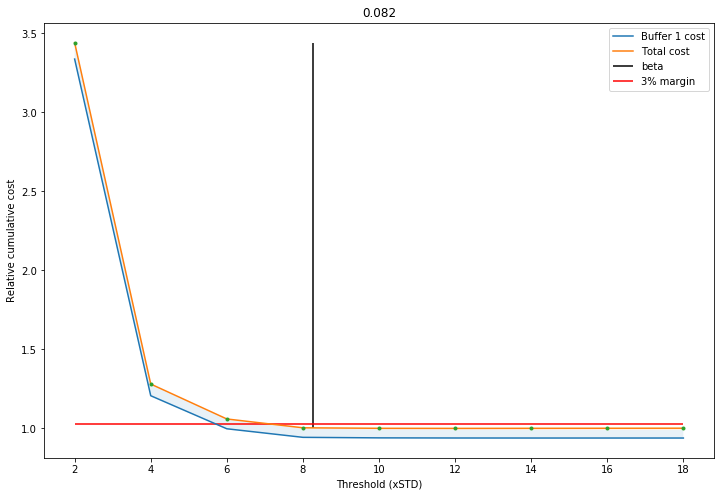

In [61]:
scale = 0.33

beta = beta_ss#betas[scale]
sc_ratio = sc_ratios[scale]
cost_1,cost_2,cost_3 = zip(*costs[scale])
cost_1=np.array(cost_1)
cost_2=np.array(cost_2)
cost_3=np.array(cost_3)
t_cost = np.array(cost_1)+np.array(cost_2)+np.array(cost_3)
min_t_cost = min(t_cost)
t_cost = t_cost/min_t_cost

cost_1=np.array(cost_1)/min_t_cost
cost_2=np.array(cost_2)/min_t_cost
cost_3=np.array(cost_3)/min_t_cost

indexes = np.where(t_cost < 5)[0]

plt.figure(figsize=(12,8))

plt.plot(hedging[indexes],cost_1[indexes],label="Buffer 1 cost")
#plt.plot(hedging[indexes],cost_1[indexes],"o")
#plt.plot(hedging[indexes],cost_2[indexes])
plt.fill_between(hedging[indexes],cost_1[indexes]+cost_2[indexes],cost_1[indexes],alpha=0.1)
plt.fill_between(hedging[indexes],t_cost[indexes],cost_1[indexes]+cost_2[indexes],alpha=0.1)
plt.plot(hedging[indexes],t_cost[indexes],label="Total cost")
plt.plot(hedging[indexes],t_cost[indexes],".")
plt.vlines(beta,min(t_cost[indexes]),max(t_cost[indexes]),label="beta")
plt.hlines(1.03,min(hedging[indexes]),max(hedging[indexes]),color="r",label="3% margin")
plt.title("{:.3f}".format(sc_ratio))
plt.ylabel("Relative cumulative cost")
plt.xlabel("Threshold (xSTD)")
plt.legend()

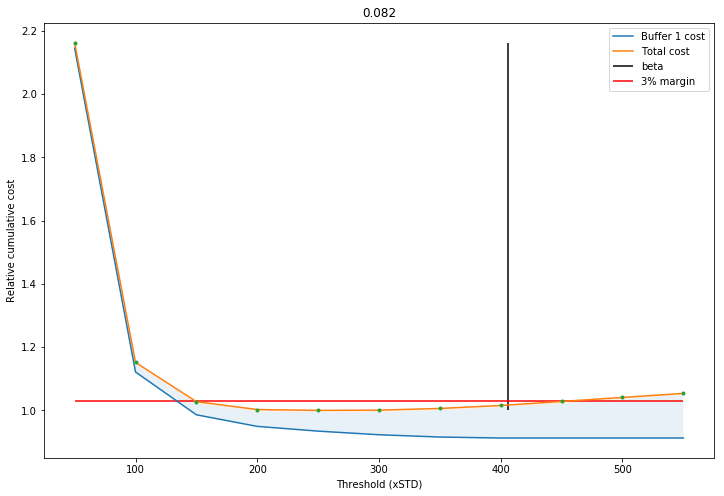

In [81]:
scale = 0.33

beta = betas[scale]
sc_ratio = sc_ratios[scale]
cost_1,cost_2,cost_3 = zip(*costs[scale])
cost_1=np.array(cost_1)
cost_2=np.array(cost_2)
cost_3=np.array(cost_3)
t_cost = np.array(cost_1)+np.array(cost_2)+np.array(cost_3)
min_t_cost = min(t_cost)
t_cost = t_cost/min_t_cost

cost_1=np.array(cost_1)/min_t_cost
cost_2=np.array(cost_2)/min_t_cost
cost_3=np.array(cost_3)/min_t_cost

indexes = np.where(t_cost < 2e6)[0]

plt.figure(figsize=(12,8))

plt.plot(hedging[indexes],cost_1[indexes],label="Buffer 1 cost")
#plt.plot(hedging[indexes],cost_1[indexes],"o")
#plt.plot(hedging[indexes],cost_2[indexes])
plt.fill_between(hedging[indexes],cost_1[indexes]+cost_2[indexes],cost_1[indexes],alpha=0.1)
plt.fill_between(hedging[indexes],t_cost[indexes],cost_1[indexes]+cost_2[indexes],alpha=0.1)
plt.plot(hedging[indexes],t_cost[indexes],label="Total cost")
plt.plot(hedging[indexes],t_cost[indexes],".")
plt.vlines(beta,min(t_cost[indexes]),max(t_cost[indexes]),label="beta")
plt.hlines(1.03,min(hedging[indexes]),max(hedging[indexes]),color="r",label="3% margin")
plt.title("{:.3f}".format(sc_ratio))
plt.ylabel("Relative cumulative cost")
plt.xlabel("Threshold (xSTD)")
plt.legend()

Text(0.5, 1.0, '0.004')

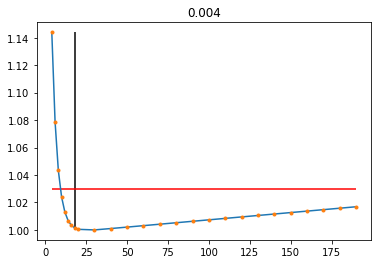

In [258]:
scale = 3
beta = betas[scale]
sc_ratio = sc_ratios[scale]
cost = costs[scale]
r_cost = cost/min(cost)
indexes = np.where(r_cost < 1.2)[0]
plt.plot(hedging[indexes],r_cost[indexes])
plt.plot(hedging[indexes],r_cost[indexes],".")
plt.vlines(beta,min(r_cost[indexes]),max(r_cost[indexes]))
plt.hlines(1.03,min(hedging[indexes]),max(hedging[indexes]),color="r")
plt.title("{:.3f}".format(sc_ratio))

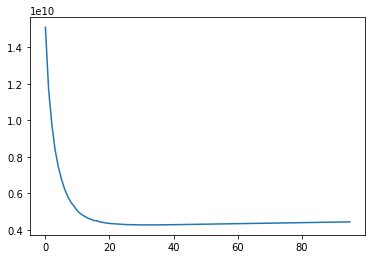

In [82]:
plt.plot(hedging,costs[1])

In [8]:
mu_demand

9.0

In [ ]:
percentile = 3.1

In [199]:
scale = 0.1

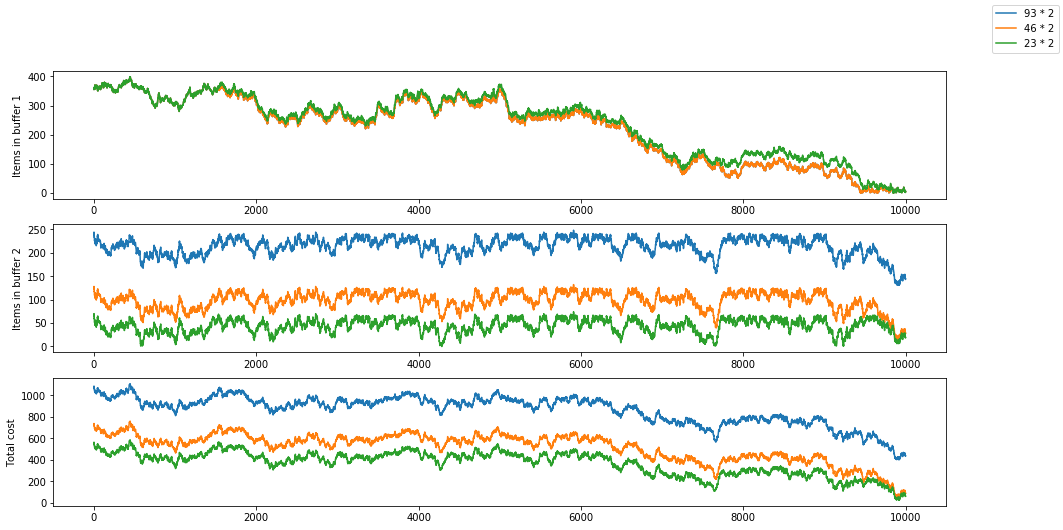

In [207]:
cost = []
rates = []
hedging = np.arange(30,200,100)

f,ax = plt.subplots(3,1,figsize=(16,8))

duration = 10000
plot_range = range(0,duration)

mu_demand = 30*scale
mu_drain = mu_demand*1.02
mu_transfer = mu_drain + (mu_drain-mu_demand)*1

slack_capacity = mu_transfer-mu_drain
std = np.sqrt(mu_drain+mu_transfer)

omega = std/slack_capacity

beta = (1/4)*(percentile**2)*(std/slack_capacity)

hedging=[beta/4,beta/2,beta]
#hedging=[beta]

init_state = (mu_drain-mu_demand)*duration*0.6


np.random.seed(5)

demand_seq = np.random.poisson(mu_demand,duration)
transfer_seq = np.random.poisson(mu_transfer,duration)
drain_seq = np.random.poisson(mu_drain,duration)

cumul =False
for h in reversed(hedging):
    thres = 2*mu_drain+h*np.sqrt(mu_drain+mu_transfer)
    
    #thres = h*10
    arrival_buffer,drain_buffer,zeta = simulate_reflected_random_walk_repeat(
        demand_seq[:duration],
        transfer_seq[:duration],
        drain_seq[:duration],
        thres,
        init_state=init_state,
    flow=False)
    
    #print(np.where(drain_buffer == 0))
    
    cost.append(sum(arrival_buffer*c1)+sum(drain_buffer*c2))
    rates.append(zeta*mu_transfer)
    #plt.plot(drain_buffer[j*1000:(j+1)*1000]*c2+arrival_buffer[j*1000:(j+1)*1000]*c1)
    if cumul:
        ax[1].plot(np.cumsum(drain_buffer)[plot_range],label=int(h))
        ax[0].plot(np.cumsum(arrival_buffer)[plot_range])
        ax[2].plot(np.cumsum(arrival_buffer*c1+drain_buffer*c2)[plot_range])
    else:
        ax[1].plot((drain_buffer)[plot_range])
        #ax[1].plot(np.ones(len(plot_range))*thres,".-")
        ax[0].plot((arrival_buffer)[plot_range],label="{} * {}".format(int(h),int(std)))
        ax[2].plot((arrival_buffer*c1+drain_buffer*c2)[plot_range])
    #print(np.min(np.diff((arrival_buffer[1500:2000]*c1+drain_buffer[1500:2000]*c2))))
    
ax[0].set_ylabel("Items in buffer 1")
ax[1].set_ylabel("Items in buffer 2")
ax[2].set_ylabel("Total cost")
f.legend()

In [142]:
slack_capacity

0.6000000000000014

In [666]:
std/slack_capacity

4.143267631552018

In [667]:
mu_drain*c2

918.0

In [668]:
thres*c2

918.0

In [669]:
np.sum(drain_buffer == 0)

58083

In [670]:
mu_demand

300

In [671]:
rates

[309.6132,
 309.6132,
 309.6132,
 309.6132,
 309.6132,
 309.6132,
 309.6132,
 309.6132,
 309.6132,
 309.6132,
 309.61424,
 309.6132,
 309.6132,
 309.6132,
 309.6132,
 309.6132,
 309.6132,
 309.61528,
 309.6132,
 309.6132,
 309.6132,
 309.6132,
 309.6132,
 309.55184,
 309.04744]

In [672]:
mu_demand

300

In [673]:
mu_transfer

312.0

In [674]:
time_horizon

42

In [675]:
offset/std

9.976023035193208

In [676]:
offset

248

In [42]:
percentile = 1.645
#percentile = 0
percentile = 1.96
#percentile = 2.33
percentile = 3.1
#percentile = 1
#percentile = 7
slack_capacity = mu_transfer-mu_drain
std = np.sqrt(mu_drain+mu_transfer)
time_horizon = (percentile*std)**2/(2*slack_capacity)**2
offset = time_horizon*(-slack_capacity) + percentile*std*np.sqrt(time_horizon)
time_horizon = int(np.ceil(time_horizon))
offset = int(np.ceil(offset))

In [43]:
percentile*np.sqrt(3)

5.36935750346352

In [44]:
slack_capacity = mu_transfer-mu_drain
std = np.sqrt(mu_drain+mu_transfer)
beta = (1/4)*(percentile**2)*(std/slack_capacity) + slack_capacity/std

In [45]:
offset

248

In [46]:
std

2.4859605789312105

In [47]:
slack_capacity

0.06000000000000005

In [48]:
slack_capacity/std

0.024135539601273914

In [49]:
slack_capacity

0.06000000000000005

In [50]:
0.5*percentile*std/np.sqrt(time_horizon)

0.05999484826367858

In [51]:
offset/std + slack_capacity/std

99.78436589153335

In [52]:
scaling_ratio = compute_scaling_ratio(mu_drain,mu_demand,std,init_state)

In [55]:
beta

99.56614038763843

Text(0.5, 1.0, '0.121')

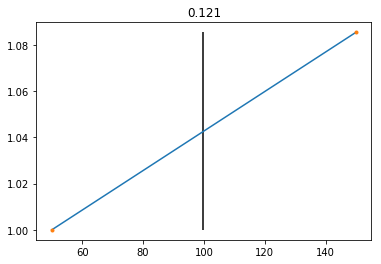

In [57]:
min_cost = min(cost)
hedging = np.array(hedging)
r_cost = np.array([c/min_cost for c in cost[::-1]])

indexes = np.where(r_cost < 1.2)[0]
plt.plot(hedging[indexes],r_cost[indexes])
plt.plot(hedging[indexes],r_cost[indexes],".")
plt.vlines(beta,min(r_cost[indexes]),max(r_cost[indexes]))
plt.title("{:.3f}".format(scaling_ratio))

Text(0.5, 1.0, '0.012')

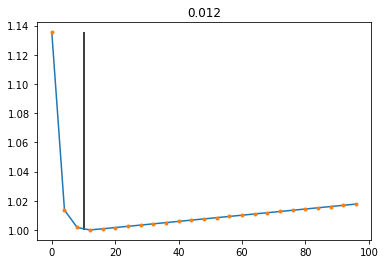

In [696]:
min_cost = min(cost)
hedging = np.array(hedging)
r_cost = np.array([c/min_cost for c in cost[::-1]])

indexes = np.where(r_cost < 1.2)[0]
plt.plot(hedging[indexes],r_cost[indexes])
plt.plot(hedging[indexes],r_cost[indexes],".")
plt.vlines(beta,min(r_cost[indexes]),max(r_cost[indexes]))
plt.title("{:.3f}".format(scaling_ratio))

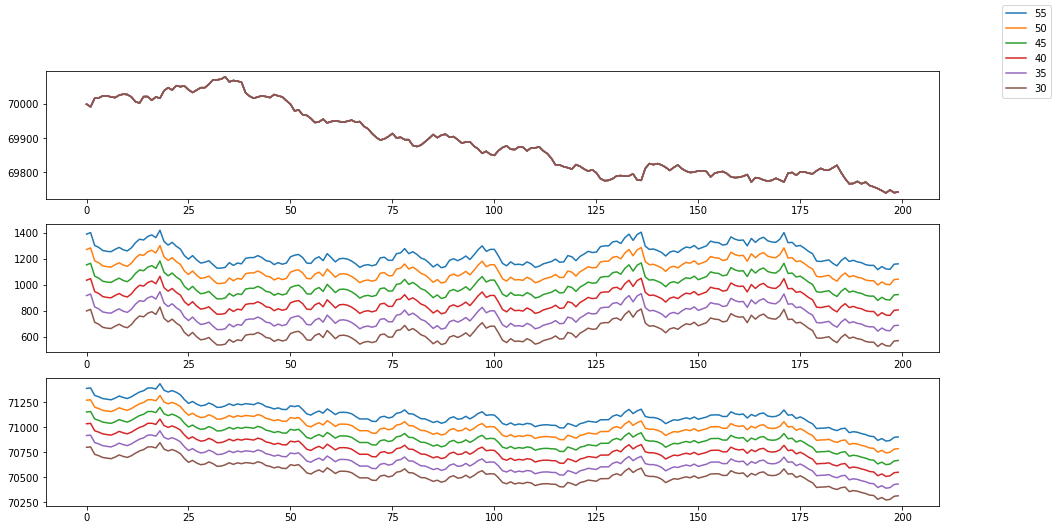

In [563]:
cost = []
hedging = np.arange(30,60,5)
init_state = 7e4
#hedging = np.arange(1,7)
j = 1
f,ax = plt.subplots(3,1,figsize=(16,8))
#plot_range = range(4000,5000)

duration = 100000
plot_range = range(0,10000)
plot_range = range(0,200)
cumul =False
for h in reversed(hedging):
    thres = mu_drain+h*np.sqrt(mu_drain+mu_transfer)
    #thres = h*10
    arrival_buffer,drain_buffer,zeta = simulate_reflected_random_walk_repeat(demand_seq[:duration],
                                                                             transfer_seq[:duration],
                                                                             drain_seq[:duration],
                                                                             thres,init_state=init_state,
                                                                            flow=False)
    cost.append(sum(arrival_buffer*c1)+sum(drain_buffer*c2))
    #plt.plot(drain_buffer[j*1000:(j+1)*1000]*c2+arrival_buffer[j*1000:(j+1)*1000]*c1)
    if cumul:
        ax[1].plot(np.cumsum(drain_buffer*c2)[plot_range],label=h)
        ax[0].plot(np.cumsum(arrival_buffer*c1)[plot_range])
        ax[2].plot(np.cumsum(arrival_buffer*c1+drain_buffer*c2)[plot_range])
    else:
        ax[1].plot((drain_buffer*c2)[plot_range],label=h)
        ax[0].plot((arrival_buffer*c1)[plot_range])
        ax[2].plot((arrival_buffer*c1+drain_buffer*c2)[plot_range])
    #print(np.min(np.diff((arrival_buffer[1500:2000]*c1+drain_buffer[1500:2000]*c2))))
f.legend()

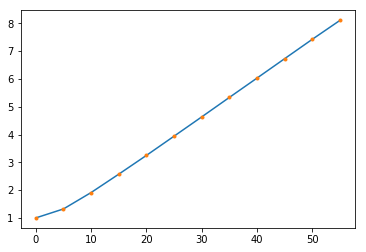

In [688]:
min_cost = min(cost)
plt.plot(hedging,[c/min_cost for c in cost[::-1]])
plt.plot(hedging,[c/min_cost for c in cost[::-1]],".")

160 -264 -264
160 -250 -250
161 -266 -266
162 -274 -274
162 -268 -268
163 -257 -257
163 -240 -240
164 -296 -296
166 -115 -115
166 -315 -315
166 -301 -301
171 -413 -413
186 -436 -436
0 0 0


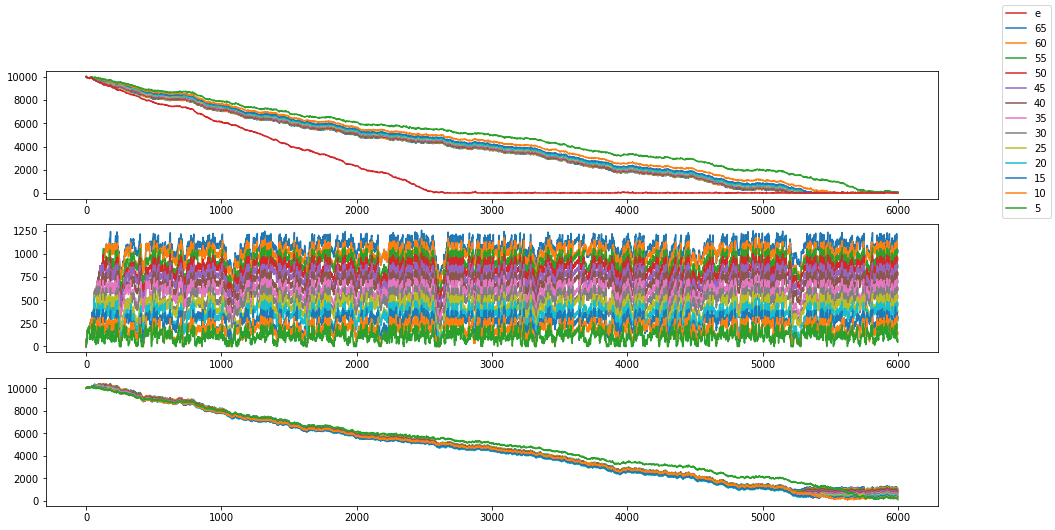

In [641]:
cost = []
hedging = np.arange(5,70,5)
init_state = 1e4
#hedging = np.arange(1,7)
j = 1
f,ax = plt.subplots(3,1,figsize=(16,8))
#plot_range = range(4000,5000)

duration = 6000
plot_range = range(0,6000)
#plot_range = range(0,300)
cumul =False
for h in reversed(hedging):
    thres = mu_drain+h*np.sqrt(mu_drain)
    #thres = h*10
    arrival_buffer,drain_buffer,zeta = simulate_reflected_random_walk(demand_seq[:duration],transfer_seq[:duration],drain_seq[:duration],thres,init_state=init_state)
    cost.append(sum(arrival_buffer*c1)+sum(drain_buffer*c2))
    #plt.plot(drain_buffer[j*1000:(j+1)*1000]*c2+arrival_buffer[j*1000:(j+1)*1000]*c1)
    if cumul:
        ax[1].plot(np.cumsum(drain_buffer*c2)[plot_range],label=h)
        ax[0].plot(np.cumsum(arrival_buffer*c1)[plot_range])
        ax[2].plot(np.cumsum(arrival_buffer*c1+drain_buffer*c2)[plot_range])
    else:
        ax[1].plot((drain_buffer*c2)[plot_range],label=h)
        ax[0].plot((arrival_buffer*c1)[plot_range])
        ax[2].plot((arrival_buffer*c1+drain_buffer*c2)[plot_range])
    #print(np.min(np.diff((arrival_buffer[1500:2000]*c1+drain_buffer[1500:2000]*c2))))
    
thres = 1e6
#thres = h*10
arrival_buffer,drain_buffer,_ = simulate_reflected_random_walk(demand_seq[:duration],transfer_seq[:duration],drain_seq[:duration],thres,init_state=init_state)
#plt.plot(drain_buffer[j*1000:(j+1)*1000]*c2+arrival_buffer[j*1000:(j+1)*1000]*c1)
if cumul:
    #ax[1].plot(np.cumsum(drain_buffer*c2)[plot_range],label="e")
    ax[0].plot(np.cumsum(arrival_buffer*c1)[plot_range],label="e")
    #ax[2].plot(np.cumsum(arrival_buffer*c1+drain_buffer*c2)[plot_range])
else:
    #ax[1].plot((drain_buffer*c2)[plot_range],label="e")
    ax[0].plot((arrival_buffer*c1)[plot_range],label="e")
    #ax[2].plot((arrival_buffer*c1+drain_buffer*c2)[plot_range])
f.legend()

In [643]:
(mu_transfer-mu_demand)/((zeta*mu_transfer)-mu_demand)

2.17406049528597

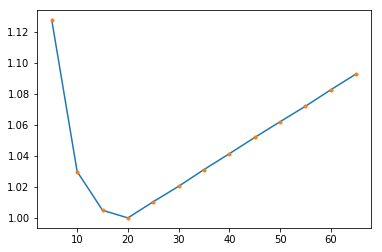

In [644]:
min_cost = min(cost)
plt.plot(hedging,[c/min_cost for c in cost[::-1]])
plt.plot(hedging,[c/min_cost for c in cost[::-1]],".")

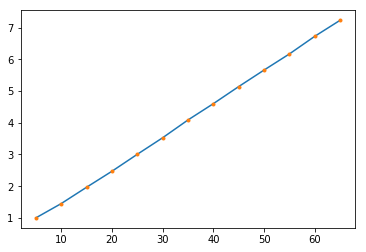

In [524]:
min_cost = min(cost)
plt.plot(hedging,[c/min_cost for c in cost[::-1]])
plt.plot(hedging,[c/min_cost for c in cost[::-1]],".")

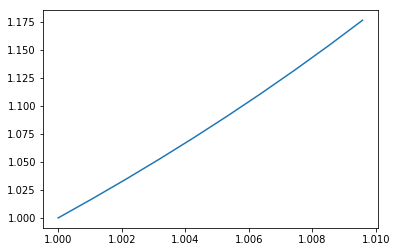

In [248]:
h = []
for i in np.arange(0.94,0.949,0.001):
    h.append(1/(1-i))
    
plt.plot(np.arange(0.94,0.949,0.001)/0.94,[i/min(h) for i in h])

In [249]:
min_cost = min(cost)

In [146]:
cost[0]-cost[1]

27580019.0

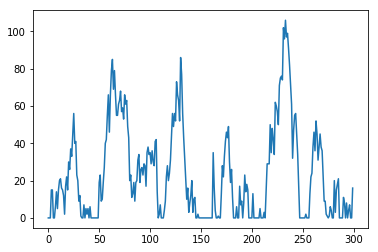

In [39]:
plt.plot(drain_buffer[:300])

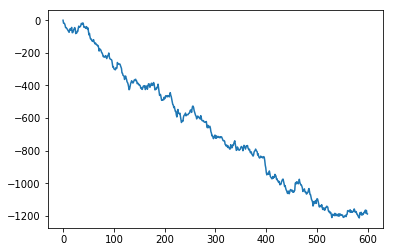

In [42]:
plt.plot(arrival_buffer[:600])

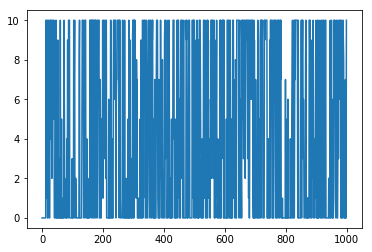

In [22]:
plt.plot(buffer_seq[:1000])

In [23]:
sum(buffer_seq)

4106735.0

In [19]:
sum(buffer_seq)

16130833.0

In [717]:
np.percentile((supply_seq-demand_seq)[(supply_seq-demand_seq) < 0],0.01)

-42.4263

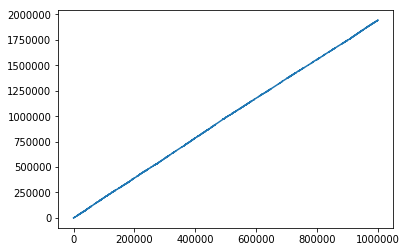

In [312]:
plt.plot(np.cumsum(supply_seq)-np.cumsum(demand_seq))

In [461]:
percentile = 1.645
#percentile = 0
#percentile = 1.96
#percentile = 2.33
slack_capacity = mu_supply-mu_demand
time_horizon = (percentile**2)*mu_supply/(2*slack_capacity**2)
offset = time_horizon*(-slack_capacity) + percentile* np.sqrt(mu_supply*2*time_horizon)
print(time_horizon*2)
time_horizon = int(np.ceil(time_horizon))
offset = int(np.ceil(offset))

47.6445427350426


In [462]:
time_horizon = (percentile**2)*mu_supply*2/slack_capacity**2
time_horizon = int(np.ceil(time_horizon))

In [416]:
y = []
for d in range(time_horizon):
    y.append(d*(slack_capacity) - percentile* np.sqrt(mu_supply*2*d))

In [398]:
y_1 = y
time_horizon_1 = time_horizon

In [413]:
y_2 = y
time_horizon_2 = time_horizon

In [407]:
time_horizon/time_horizon_1

0.7058823529411765

In [408]:
1.96/1.645

1.1914893617021276

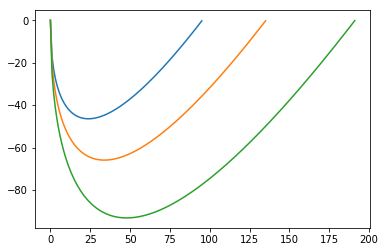

In [417]:
plt.plot(range(time_horizon),y)
plt.plot(range(time_horizon_1),y_1)
plt.plot(range(time_horizon_2),y_2)

In [370]:
y

[0.0,
 17.085145061175655,
 23.019760307253847,
 27.119838375400015,
 30.270290122351305,
 32.81387831835815,
 34.92639257973963,
 36.712260001910145,
 38.23952061450768,
 39.55543518352695,
 40.69441398502021,
 41.68243399790631,
 42.53967675080001,
 43.28219155396391,
 43.92299112646137,
 44.47279981457564,
 44.94058024470259,
 45.33391368618153,
 45.65928092176151,
 45.922273697301975,
 46.12775663671627,
 46.279993107302204,
 46.382744385463354,
 46.43934873521658,
 46.45278515947922,
 46.42572530587822,
 46.36057611100394,
 46.2595151262,
 46.12452000382025,
 45.957393282143244,
 45.759783353889546,
 45.533202312913645,
 45.27904122901532,
 44.99858328986244,
 44.693015163117266,
 44.363436864789705,
 44.010870367053855,
 43.636267136910405,
 43.24051476365686,
 42.82444280626501,
 42.38882797004037,
 41.93439870426393,
 41.46183929805834,
 40.97179353983009,
 40.464867995812554,
 39.94163495507436,
 39.402635081550386,
 38.848379807949996,
 38.27935350159996,
 37.696015428229444,

In [281]:
time_horizon

93

In [224]:
offset

47

In [802]:
thres = poisson.ppf(0.95,mu_demand)
#thres = 0
thres = poisson.ppf(0.5,mu_demand)

def idle_supply(demand_seq,supply_seq,offset):
    inv_pos = offset
    idle_supply_seq = np.zeros_like(supply_seq) 
    idle_count = 0
    for i,(d,s) in enumerate(zip(demand_seq,supply_seq)):
        if inv_pos > thres+offset:
            s = 0
            idle_count += 1
        idle_supply_seq[i] = s
        inv_pos += s-d
    #print(idle_count/len(supply_seq)) 
    return idle_supply_seq

def idle_supply_time_horizon(demand_seq,supply_seq,offset,time_horizon):
    inv_pos = offset
    inv_pos_seq = np.zeros_like(supply_seq)
    days_count = 0
    for i,(d,s) in enumerate(zip(demand_seq,supply_seq)):
        if (inv_pos > thres+offset) and days_count >= time_horizon:
            s = 0
            days_count = 0
        idle_supply_seq[i] = s
        inv_pos += s-d
        inv_pos_seq[i] = inv_pos
        days_count += 1
    return inv_pos_seq

def idle_supply_time_horizon_smooth(demand_seq,supply_seq,offset,time_horizon):
    inv_pos = offset
    inv_pos_seq = np.zeros_like(supply_seq)
    days_count = 0
    just_idled = False
    for i,(d,s) in enumerate(zip(demand_seq,supply_seq)):
        surplus = inv_pos - offset
        if surplus > 0 and ((days_count >= time_horizon) or just_idled):
            if d > surplus:
                s = d-surplus
            else:
                s = 0
            days_count=0
            just_idled = True
        else:
            just_idled = False
            
        inv_pos += s-d
        inv_pos_seq[i] = inv_pos
        if not just_idled:
            days_count += 1
            
    return inv_pos_seq

def work_supply_time_horizon_smooth(demand_seq,supply_seq,offset,time_horizon):
    inv_pos = offset
    inv_pos_seq = np.zeros_like(supply_seq)
    days_count = 0
    just_idled = True
    for i,(d,s) in enumerate(zip(demand_seq,supply_seq)):
        surplus = inv_pos - offset
        if surplus > 0 and ((days_count >= time_horizon) or just_idled):
            days_count = 0
            if d > surplus:
                s = d-surplus
            else:
                s = 0
            days_count=0
            just_idled = True
        else:
            days_count += 1
            just_idled = False
            
        inv_pos += s-d
        inv_pos_seq[i] = inv_pos
            
    return inv_pos_seq

def idle_supply_smooth(demand_seq,supply_seq,offset):
    inv_pos = offset
    idle_supply_seq = np.zeros_like(supply_seq) 
    idle_count = 0
    inv_pos_array = np.zeros_like(supply_seq)
    for i,(d,s) in enumerate(zip(demand_seq,supply_seq)):
        surplus = inv_pos - offset
        if surplus > 0:
            if d > surplus:
                s = d-surplus
            else:
                s = 0
            idle_count += 1
            
        idle_supply_seq[i] = s
        inv_pos += s-d
        inv_pos = min(inv_pos,offset)
        inv_pos_array[i] = inv_pos

    #print(idle_count/len(supply_seq)) 
    print(inv_pos)
    return inv_pos_array

In [126]:
slack_capacity/np.sqrt(2*mu_demand)

0.17102631376487096

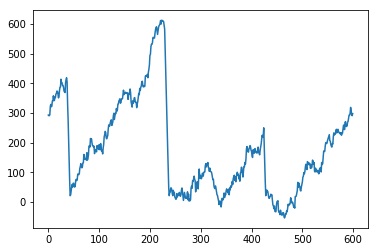

In [197]:
point = 1400
plt.plot(inv_pos_seq[point-100:point+500])

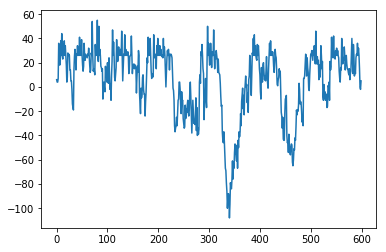

In [678]:
point = 1400
plt.plot(inv_pos_seq[point-100:point+500])

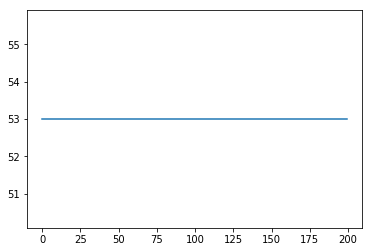

In [801]:
point = 1400
plt.plot(inv_pos_seq[point-100:point+100])

In [310]:
offset

36

In [232]:
time_horizon*slack_capacity/2

90.67500000000013

In [308]:
slack_capacity

1.9500000000000028

In [807]:
inv_pos_seq = work_supply_time_horizon_smooth(demand_seq,supply_seq,53,12)

print(np.mean(inv_pos_seq < 0))

0.098125


In [806]:
inv_pos_seq = idle_supply_time_horizon_smooth(demand_seq,supply_seq,53,12)

print(np.mean(inv_pos_seq < 0))

0.098125


In [798]:
stocks = inv_pos_seq.copy()
stocks[inv_pos_seq < 0] = 0
np.mean(stocks)

36.558295

In [744]:
inv_pos_seq = idle_supply_time_horizon_smooth(demand_seq,supply_seq,41,69)

print(np.mean(inv_pos_seq < 0))

0.058607


In [745]:
stocks = inv_pos_seq.copy()
stocks[inv_pos_seq < 0] = 0
np.mean(stocks)

106.637556

In [83]:
inv_pos_seq = idle_supply_time_horizon(demand_seq,supply_seq,offset,time_horizon)

print(np.mean(inv_pos_seq < 0))
#plt.plot(inv_pos_seq[827341-10:827341+10])
#plt.plot(inv_pos_seq[827341-10:827341+10],".")

NameError: name 'idle_supply_seq' is not defined

In [1069]:
stocks = inv_pos_seq.copy()
stocks[inv_pos_seq < 0] = 0
np.mean(stocks)

102.929782

In [84]:
idle_supply_seq,inv_pos_seq = idle_supply_smooth(demand_seq,supply_seq, np.ceil(offset))
#inv_pos_seq = offset + np.cumsum(idle_supply_seq)-np.cumsum(demand_seq)
print(np.mean(inv_pos_seq < 0))
#plt.plot(inv_pos_seq[827341-10:827341+10])
#plt.plot(inv_pos_seq[827341-10:827341+10],".")

plt.plot(inv_pos_seq[:1200])

-7.0


ValueError: too many values to unpack (expected 2)

In [535]:
n_sims = 100000
demand_sum = np.random.poisson(mu_demand*np.ceil(time_horizon),n_sims)
supply_sum = np.random.poisson(mu_supply*np.ceil(time_horizon),n_sims)

print(np.mean((demand_sum-supply_sum) > np.ceil(offset)))

0.04674


In [88]:
offset+time_horizon*slack_capacity

129.60000000000014

In [161]:
1001 % 100

1

In [468]:
offset

36

In [467]:
time_horizon*slack_capacity/2

93.60000000000014

(0.0462896875, 0.04765, 130.77993218749998)

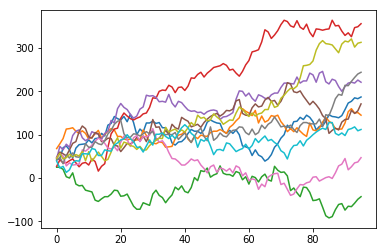

In [480]:
np.random.seed(500)
n_sims = 100000
#n_sims = 20
stockouts = []
last_day_stockouts = []
last_day_stockouts_vals = []
ave_inventories = []
sim_time_horizon = time_horizon
for i in range(n_sims):
    demand = np.random.poisson(mu_demand,sim_time_horizon)
    supply = np.random.poisson(mu_supply,sim_time_horizon)
    inv_pos_seq = offset + np.cumsum(supply)-np.cumsum(demand)
    stockouts.append(np.sum(inv_pos_seq < 0))
    last_day_stockouts.append(inv_pos_seq[-1] < offset)
    if last_day_stockouts[-1]:
        last_day_stockouts_vals.append(inv_pos_seq[-1]-offset)
    
    ave_inventories.append(np.mean(inv_pos_seq))
    if i % 10000 == 0:
        plt.plot(inv_pos_seq)
    
sum(stockouts)/(sim_time_horizon*n_sims),np.sum(last_day_stockouts)/(n_sims),np.mean(ave_inventories)


In [482]:
offset

36

In [481]:
np.median(last_day_stockouts_vals)

-36.0

In [464]:
for offset in range(200):
    stock_out_probs = []
    for d in range(1,time_horizon+1):
        stock_out_prob = norm.cdf(-offset,slack_capacity*d,np.sqrt(2*mu_supply*d))
        stock_out_probs.append(stock_out_prob)
    overal_stockout_prob = np.mean(stock_out_probs)
    #print(overal_stockout_prob)
    if overal_stockout_prob < 0.05:
        break

In [465]:
time_horizon

96

In [786]:
def get_percentile_deficit(cycle_dur,slack_capacity,variance,percentile = 0.5):
    mu = slack_capacity*cycle_dur
    std = np.sqrt(variance*cycle_dur)
    cum_deficit_prob = norm.cdf(0,mu,std)
    cum_percentile = 0
    prev_cum_prob = cum_deficit_prob
    for i in range(10000):
        cum_prob = norm.cdf(-i,mu,std)
        prob = (prev_cum_prob - cum_prob)/cum_deficit_prob
        cum_percentile += prob
        if cum_percentile >= percentile:
            return i
        prev_cum_prob = cum_prob
        
a = get_percentile_deficit(time_horizon/4,slack_capacity,2*mu_supply)
#get_percentile_deficit(slack_capacity,2*mu_supply,time_horizon)
print(a)

def compute_recovery_time(slack_capacity,variance,deficit,bound = 2.33):
    dur = ((bound*np.sqrt(variance)+np.sqrt(bound**2*variance+4*slack_capacity*deficit))/(2*slack_capacity))**2
    return int(np.ceil(dur))

print(compute_recovery_time(slack_capacity,2*mu_supply,a))

def get_average_stockout_prob(duration,slack_capacity,variance,start):
    stock_out_probs = []
    for d in range(1,duration+1):
        stock_out_prob = norm.cdf(0,start+slack_capacity*d,np.sqrt(variance*d))
        stock_out_probs.append(stock_out_prob)
    average_stockout_prob = np.mean(stock_out_probs)
    return average_stockout_prob

def compute_stockout_prob_and_inventory_cost(cycle_dur,slack_capacity,variance,offset):
    mu = slack_capacity*cycle_dur
    std = np.sqrt(variance*cycle_dur)
    cum_deficit_prob = norm.cdf(0,mu,std)
    #print(cum_deficit_prob)
    deficit = get_percentile_deficit(cycle_dur,slack_capacity,variance,0.95)
    #print(deficit)
    rec_dur = compute_recovery_time(slack_capacity,variance,deficit)
    #print(rec_dur)
    cycle_stockout_prob = get_average_stockout_prob(cycle_dur,slack_capacity,variance,offset)
    
    rec_dur = int(np.ceil(deficit/slack_capacity))
    print(rec_dur)
    rec_stockout_prob = get_average_stockout_prob(rec_dur,slack_capacity,variance,offset-deficit)
    #print(cycle_stockout_prob,rec_stockout_prob)
    
    effective_duration = (cycle_dur+cum_deficit_prob*rec_dur)
    #print(cycle_dur/effective_duration)
    
    overall_stockout_prob = (cycle_dur*cycle_stockout_prob+cum_deficit_prob*rec_dur*rec_stockout_prob)/effective_duration
    
    overall_inventory_cost = (cycle_dur*(0.5*slack_capacity*cycle_dur+offset)+cum_deficit_prob*rec_dur*(0.5*slack_capacity*rec_dur+offset-deficit))/effective_duration
    #print(overall_inventory_cost)
    return overall_stockout_prob,overall_inventory_cost

26
218


In [787]:
time_horizon/4

24.0

In [788]:
variance = 2*mu_supply

In [789]:
min_inv_cost = np.inf
min_cycle_dur = None
min_offset = None
for cycle_dur in range(1,int(time_horizon)):

    for offset in range(200):
        overall_stockout_prob,inv_cost = compute_stockout_prob_and_inventory_cost(cycle_dur,slack_capacity,variance,offset)
        #print(overall_stockout_prob)
        if overall_stockout_prob < 0.05:
            break
    
    print(cycle_dur,inv_cost)
    if inv_cost < min_inv_cost:
        print(cycle_dur)
        min_inv_cost = inv_cost
        min_cycle_dur = cycle_dur
        min_offset = offset
    
print(offset)

12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
1 44.51941163356536
1
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
2 51.450199107013205
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
3 55.456041997108095
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
4 60.20398854011554
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
2

KeyboardInterrupt: 

In [794]:
min_offset

53

In [795]:
min_cycle_dur

1

In [796]:
min_inv_cost

44.51941163356536

In [793]:
time_horizon

96

In [661]:
int(time_horizon)*(0.5*slack_capacity)

93.60000000000014

In [662]:
inv_cost

120.81782054639562

In [644]:
print(overal_stockout_prob)

0.04845734901862475


In [530]:
overal_stockout_prob

0.04845734901862475

In [473]:
probs = []
deficit = 10000
for i in range(deficit):
    v = -offset-i
    mu = slack_capacity*time_horizon
    std = np.sqrt(2*mu_supply*time_horizon)
    probs.append(norm.cdf(v,mu,std))
    #print(i,probs[-1])
    
np.sum(-np.diff(probs)*np.arange(1,deficit)/norm.cdf(-offset,mu,std))

43.22540790940915

In [474]:
offsets = []
for dur in range(1,time_horizon+1):
    for offset in range(200):
        stock_out_probs = []
        for d in range(1,dur+1):
            stock_out_prob = norm.cdf(-offset,slack_capacity*d,np.sqrt(2*mu_supply*d))
            stock_out_probs.append(stock_out_prob)
        overal_stockout_prob = np.mean(stock_out_probs)
        #print(overal_stockout_prob)
        if overal_stockout_prob < 0.05:
            break
    #print(dur,offset)
    offsets.append(offset)

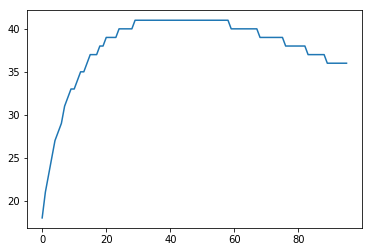

In [475]:
plt.plot(offsets)

In [434]:
norm.cdf(-offset,mu,std)

0.02449670717616564

In [440]:
offset

36

In [446]:
mu

187.20000000000027

In [454]:
(-np.diff(probs)/norm.cdf(-offset,mu,std))[:50]

array([0.02050853, 0.02015394, 0.01980393, 0.01945849, 0.01911759,
       0.0187812 , 0.01844929, 0.01812184, 0.01779881, 0.01748018,
       0.01716593, 0.01685601, 0.0165504 , 0.01624906, 0.01595197,
       0.01565909, 0.0153704 , 0.01508585, 0.01480542, 0.01452908,
       0.01425678, 0.01398849, 0.01372419, 0.01346384, 0.01320739,
       0.01295482, 0.0127061 , 0.01246118, 0.01222003, 0.01198261,
       0.01174889, 0.01151884, 0.01129241, 0.01106957, 0.01085029,
       0.01063452, 0.01042223, 0.01021338, 0.01000794, 0.00980588,
       0.00960714, 0.0094117 , 0.00921951, 0.00903055, 0.00884478,
       0.00866215, 0.00848263, 0.00830619, 0.00813278, 0.00796238])

In [444]:
-np.diff(probs)/norm.cdf(-offset,mu,std)

array([ 0.02050853,  0.02015394,  0.01980393, ..., -0.        ,
       -0.        , -0.        ])

In [283]:
offset

36

In [895]:
np.sum(last_day_stockouts)/(n_sims)

0.052

In [896]:
sum(stockouts)/(int(np.ceil(time_horizon))*n_sims)

0.0335

In [766]:
np.sum(last_day_stockouts)

43

In [909]:
np.sum(last_day_stockouts)/sum(stockouts)

0.04420866489832007

In [1119]:
np.mean(stockouts)

2.31787

In [1116]:
stockouts = np.array(stockouts)

In [1117]:
np.median(stockouts[stockouts > 0])

7.0

(array([9274., 3759., 2025., 1756., 1099., 1094.,  848.,  546.,  512.,
         164.]),
 array([ 1. ,  5.6, 10.2, 14.8, 19.4, 24. , 28.6, 33.2, 37.8, 42.4, 47. ]),
 <a list of 10 Patch objects>)

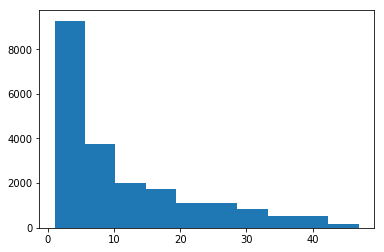

In [1118]:
plt.hist(stockouts[stockouts > 0])

(array([8.2182e+04, 3.6430e+03, 2.3720e+03, 1.7600e+03, 1.3980e+03,
        1.1520e+03, 1.0320e+03, 8.2200e+02, 7.4300e+02, 6.3300e+02,
        5.6600e+02, 5.3300e+02, 4.6600e+02, 4.2600e+02, 3.9100e+02,
        3.5700e+02, 3.0200e+02, 2.8200e+02, 2.6400e+02, 2.3200e+02,
        2.0800e+02, 1.3000e+02, 8.8000e+01, 1.8000e+01]),
 array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32,
        34, 36, 38, 40, 42, 44, 46, 48]),
 <a list of 24 Patch objects>)

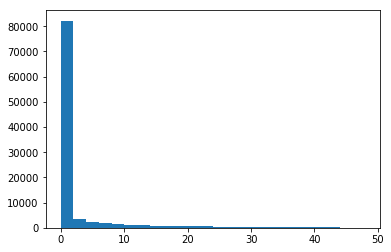

In [1104]:
plt.hist(stockouts,bins=range(0,50,2))

In [1102]:
2*time_horizon

48

In [883]:
norm.cdf(-offset,slack_capacity*10,np.sqrt(mu_supply*10))

0.005402319138037798

In [768]:
int(np.ceil(time_horizon))

24